In [1]:
import pandas as pd
import numpy as np

import rasterio
from skimage.transform import resize
from skimage.transform import rotate
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

from sklearn.model_selection import train_test_split

from datetime import timedelta
from skimage.draw import polygon
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

from utils import process_yield_data
from pathlib import Path

import matplotlib.pyplot as plt

#### Import Yield Data

In [2]:
YIELD_DATA_PATH = Path("./combined_yield_data.csv")
yield_data_weekly = process_yield_data(YIELD_DATA_PATH)

            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre
Date                                                                 
2012-01-02          23400.0                      23400.0          2.0
2012-01-03          26064.0                      49464.0          3.0
2012-01-04          32382.0                      81846.0          3.0
2012-01-05          69804.0                     151650.0          7.0
2012-01-06          18000.0                     169650.0          2.0

Number of Yield Data Points:  3970

Column Names: Index(['Volume (Pounds)', 'Cumulative Volumne (Pounds)', 'Pounds/Acre'], dtype='object')
Number of Yield Data Points: 2879
Yield data with time features:
            Volume (Pounds)  Cumulative Volumne (Pounds)  Pounds/Acre  \
Date                                                                    
2012-03-04         525753.0                    1785843.0    18.333333   
2012-03-11        2949534.0                    4735377.0    51.666667   
2012-03-18   

#### Define the Model

In [3]:
target_shape = (512, 512)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using mps device


### Old Model

In [4]:
# class CNNFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(CNNFeatureExtractor, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.5)
#         self.flattened_size = self._get_conv_output((1, *target_shape))
#         self.fc1 = nn.Linear(self.flattened_size, 512)

#     def _get_conv_output(self, shape):
#         x = torch.rand(1, *shape)
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         n_size = x.view(1, -1).size(1)
#         return n_size

#     def forward(self, x):
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         x = self.dropout(x)
#         x = x.view(-1, self.flattened_size)
#         x = F.relu(self.fc1(x))
#         return x
    
# class HybridModel(nn.Module):
#     def __init__(self, cnn_feature_extractor, lstm_hidden_size=64, lstm_layers=1):
#         super(HybridModel, self).__init__()
#         self.cnn = cnn_feature_extractor
#         self.lstm = nn.LSTM(input_size=512, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
#         self.fc1 = nn.Linear(lstm_hidden_size + 4, 64)
#         self.fc2 = nn.Linear(64, target_shape[0] * target_shape[1])  # Predict a value per pixel
#         self.target_shape = target_shape

#     def forward(self, x, time_features):
#         batch_size, time_steps, C, H, W = x.size()
#         c_in = x.view(batch_size * time_steps, C, H, W)
#         c_out = self.cnn(c_in)
#         r_in = c_out.view(batch_size, time_steps, -1)
#         r_out, (h_n, c_n) = self.lstm(r_in)
#         r_out = r_out[:, -1, :]
#         x = torch.cat((r_out, time_features), dim=1)  # Concatenate LSTM output with time features
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         x = x.view(batch_size, *self.target_shape)  # Reshape to the target shape
#         return x

### New Model

In [5]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = self._get_conv_output((1, 512, 512))
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=16, lstm_layers=1, dropout_rate=0.6):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 4, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 512 * 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.target_shape = (512, 512)

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = x.view(batch_size, *self.target_shape)
        return x

#### Initialize Function

In [6]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

batch_size = 16
epochs = 50

### Functions for prediction

In [7]:
from inference_utils import (
    preprocess_image,
    compute_mean_std,
    load_evi_data_and_prepare_features,
    find_closest_date,
    find_closest_date_in_df,
    mask_evi_data,
    predict,
    predict_weekly_yield,
    augment_image,
    prepare_dataset,
    train_and_evaluate,
    sync_evi_yield_data,
    CustomDataset,
    load_evi_data,
    find_common_date_range
)


In [8]:
# Load EVI data and prepare time features, including the dataset
evi_data_dir = "./landsat_evi_monterey_masked"
train_loader, val_loader, mean, std, dataset = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True)

Processed file 1/84 in 1.98s
Processed file 2/84 in 2.10s
Processed file 3/84 in 2.11s
Processed file 4/84 in 1.92s
Processed file 5/84 in 1.55s
Processed file 6/84 in 2.04s
Processed file 7/84 in 2.11s
Processed file 8/84 in 1.81s
Processed file 9/84 in 2.12s
Processed file 10/84 in 1.88s
Processed file 11/84 in 2.28s
Processed file 12/84 in 1.68s
Processed file 13/84 in 2.25s
Processed file 14/84 in 1.79s
Processed file 15/84 in 1.69s
Processed file 16/84 in 1.64s
Processed file 17/84 in 2.00s
Processed file 19/84 in 1.78s
Processed file 20/84 in 1.84s
Processed file 21/84 in 2.09s
Processed file 22/84 in 1.94s
Processed file 23/84 in 1.74s
Processed file 24/84 in 1.72s
Processed file 25/84 in 2.15s
Processed file 26/84 in 1.80s
Processed file 27/84 in 1.87s
Processed file 28/84 in 2.33s
Processed file 29/84 in 2.12s
Processed file 30/84 in 2.17s
Processed file 31/84 in 1.86s
Processed file 32/84 in 2.17s
Processed file 33/84 in 2.29s
Processed file 34/84 in 1.88s
Processed file 35/8

### Model Evaluation (Cross Validation)

In [10]:
# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []
medae_scores = []

# Lists to store losses for plotting
all_train_losses = []
all_val_losses = []

epochs = 50
patience = 5 
early_stop = False

# Cross-validation with train_and_evaluate
for fold, (train_index, val_index) in enumerate(tscv.split(yield_data_weekly)):
    print(f"Fold {fold + 1}")

    # Check if indices are within bounds
    if max(train_index) >= len(dataset) or max(val_index) >= len(dataset):
        print(f"Error: Indices out of range for fold {fold + 1}")
        continue 

    # Create Subsets for the current fold
    fold_train_subset = torch.utils.data.Subset(dataset, train_index)
    fold_val_subset = torch.utils.data.Subset(dataset, val_index)

    # DataLoaders for the current fold
    fold_train_loader = DataLoader(fold_train_subset, batch_size=batch_size, shuffle=True)
    fold_val_loader = DataLoader(fold_val_subset, batch_size=batch_size, shuffle=False)

    # Instantiate a new model for each fold
    model = HybridModel(CNNFeatureExtractor())
    model.apply(weights_init)
    model.to(device)

    # Set up the optimizer, scheduler, and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.MSELoss()

    # Train and evaluate the model using the function
    val_loss, train_losses, val_losses, val_mse, val_rmse, val_mae, val_medae, val_r2 = train_and_evaluate(
        model, fold_train_loader, fold_val_loader, optimizer, scheduler, criterion, epochs, device
    )
    
    # Store the train and val losses for visualization
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Model evaluation on the validation set
    model.eval()
    with torch.no_grad():
        outputs_val = []
        labels_val = []
        for evi_batch, label_batch, time_features_batch, timestamp in fold_val_loader:
            evi_batch, label_batch, time_features_batch = evi_batch.to(device), label_batch.to(device), time_features_batch.to(device)
            outputs_batch = model(evi_batch, time_features_batch) # lbs/pixel
            outputs_val.extend(outputs_batch.cpu().numpy().flatten())
            label_batch = label_batch.unsqueeze(1).unsqueeze(2).expand(-1, target_shape[0], target_shape[1])
            labels_val.extend(label_batch.cpu().numpy().flatten())

    # Flatten the outputs and labels
    outputs_val = np.array(outputs_val)
    labels_val = np.array(labels_val)

    # Calculate val metrics
    mse = mean_squared_error(labels_val, outputs_val)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_val, outputs_val)
    r2 = r2_score(labels_val, outputs_val)
    medae = median_absolute_error(labels_val, outputs_val)

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    medae_scores.append(medae)

# Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average MedAE: {np.mean(medae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Fold 1
# of samples - Training   - 111
# of samples - Validation - 106


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 1, Loss: 11.248353685651507


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.3010153429848807


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 2, Loss: 8.721095357622419


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.23148738060678756


100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


Epoch 3, Loss: 7.625292028699603


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.22426633749689376


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch 4, Loss: 7.087157113211496


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.18654893551554


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch 5, Loss: 5.3816375732421875


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.18592813717467443


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch 6, Loss: 4.5112089429582864


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17656970343419484


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch 7, Loss: 3.890232358660017


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16047479531594686


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Epoch 8, Loss: 3.383253335952759


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14700501731463841


100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch 9, Loss: 2.9405572754996165


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1415576370699065


100%|██████████| 7/7 [00:09<00:00,  1.38s/it]


Epoch 10, Loss: 2.7003275666918074


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1363366719867502


100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch 11, Loss: 2.2553629875183105


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13056667521595955


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 12, Loss: 2.4201361622129167


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12614597326942853


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch 13, Loss: 1.9987150260380335


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12223673132913453


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch 14, Loss: 1.795242496899196


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11885008215904236


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch 15, Loss: 1.8262953077043806


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11584675338651453


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch 16, Loss: 1.620827317237854


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11315488283123289


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch 17, Loss: 1.4004546403884888


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11090411671570369


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch 18, Loss: 1.353631615638733


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10893702852938857


100%|██████████| 7/7 [00:08<00:00,  1.29s/it]


Epoch 19, Loss: 1.1578089935438973


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10714737725045


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch 20, Loss: 1.0405165127345495


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10561732522078923


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch 21, Loss: 1.0262547390801566


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10423524677753448


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch 22, Loss: 0.9876355699130467


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10295261602316584


100%|██████████| 7/7 [00:09<00:00,  1.33s/it]


Epoch 23, Loss: 0.8715131197656903


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10172645508178643


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch 24, Loss: 0.8019474829946246


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10060610914868968


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 25, Loss: 0.6800888010433742


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09961421122508389


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch 26, Loss: 0.7092087353978839


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09872412229222911


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Epoch 27, Loss: 0.637022248336247


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09780901963157314


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch 28, Loss: 0.6509052429880414


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09666030960423606


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch 29, Loss: 0.5603058295590537


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0959508755643453


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch 30, Loss: 0.488627416746957


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.095407884567976


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch 31, Loss: 0.4182614641530173


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09458430537155696


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch 32, Loss: 0.47087980593953815


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09338094320680414


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Epoch 33, Loss: 0.3835924140044621


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09256566462240048


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch 34, Loss: 0.3439438726220812


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09126332628407649


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch 35, Loss: 0.32109113676207407


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09085821014429842


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 36, Loss: 0.30895013894353596


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09047984704375267


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 37, Loss: 0.2956686999116625


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09014423603990249


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch 38, Loss: 0.28030271189553396


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08985194570517965


100%|██████████| 7/7 [00:09<00:00,  1.30s/it]


Epoch 39, Loss: 0.29171307597841534


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08959574937554342


100%|██████████| 7/7 [00:09<00:00,  1.34s/it]


Epoch 40, Loss: 0.2700278801577432


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0893616753497294


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch 41, Loss: 0.23114019206592015


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08914820916418519


100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


Epoch 42, Loss: 0.19604621827602386


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08895543217658997


100%|██████████| 7/7 [00:09<00:00,  1.36s/it]


Epoch 43, Loss: 0.19805127382278442


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08877941546961665


100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


Epoch 44, Loss: 0.19234347769192287


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08861954749694892


100%|██████████| 7/7 [00:09<00:00,  1.32s/it]


Epoch 45, Loss: 0.1783734687737056


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0884739990745272


100%|██████████| 7/7 [00:08<00:00,  1.27s/it]


Epoch 46, Loss: 0.20707073275532042


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08834024196091507


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Epoch 47, Loss: 0.16633384355476924


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08821316276277814


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch 48, Loss: 0.16132424558912004


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08809218855042543


100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


Epoch 49, Loss: 0.14248060222182954


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.08797897398471832


100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


Epoch 50, Loss: 0.14388624152966908
Validation Loss: 0.08787392518882241


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.08672316372394562, RMSE: 0.29448798298835754, MAE: 0.22311383485794067, MedAE: 0.2024248242378235, R-squared: -1.2072215483961766
Fold 2
# of samples - Training   - 217
# of samples - Validation - 106


100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch 1, Loss: 10.42180505820683


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.27395414880343844


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 2, Loss: 7.582111971718924


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.21358860922711237


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 3, Loss: 5.455179214477539


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2064778474824769


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 4, Loss: 4.161159907068525


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17305392239774978


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 5, Loss: 3.245404396738325


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16126468245472228


100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch 6, Loss: 2.62566671201161


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15029290079006127


100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch 7, Loss: 1.9153027534484863


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1444232136543308


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 8, Loss: 1.5449562243052892


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13832085845725878


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 9, Loss: 1.3203186052186149


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13351152797362634


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 10, Loss: 1.0348609132426125


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13088238851300307


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 11, Loss: 0.8737355811255318


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12883839676422731


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 12, Loss: 0.9085550223078046


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12727848693196261


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 13, Loss: 0.6497454302651542


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12604217550584249


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 14, Loss: 0.5407480405909675


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12500541850126215


100%|██████████| 14/14 [00:18<00:00,  1.32s/it]


Epoch 15, Loss: 0.4881787491696222


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12412892102396914


100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


Epoch 16, Loss: 0.45045971657548634


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12342256513823356


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 17, Loss: 0.3938619153840201


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12283427906887871


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 18, Loss: 0.30253191611596514


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12231516518763133


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 19, Loss: 0.2896799977336611


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1218826586513647


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 20, Loss: 0.2582551326070513


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12154811866847533


100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch 21, Loss: 0.19572300144604274


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12125600006298295


100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


Epoch 22, Loss: 0.17975354034985816


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12099183497152158


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 23, Loss: 0.15103496398244584


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12076183586447899


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 24, Loss: 0.13860689742224558


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12056563970898944


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 25, Loss: 0.13030279214893067


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1203892203713102


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 26, Loss: 0.10464044234582356


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12023394365262773


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 27, Loss: 0.10046829017145294


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1200990091310814


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 28, Loss: 0.08052801101335458


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1199826581204044


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 29, Loss: 0.07874957764787334


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11986383785759765


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 30, Loss: 0.0724750959447452


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1197570574419972


100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch 31, Loss: 0.0630357206932136


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11969436621958655


100%|██████████| 14/14 [00:18<00:00,  1.29s/it]


Epoch 32, Loss: 0.053496986494532654


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11961650756087952


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 33, Loss: 0.05181107736591782


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11955403742779579


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 34, Loss: 0.05177081722233977


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11949702398851514


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 35, Loss: 0.04565916769206524


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11944791996419164


100%|██████████| 14/14 [00:17<00:00,  1.23s/it]


Epoch 36, Loss: 0.030799821684403077


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11941071345271277


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 37, Loss: 0.0318102410861424


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11936757886516196


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 38, Loss: 0.029445062724075148


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11931324745611553


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 39, Loss: 0.02406522531860641


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11929254183529078


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 40, Loss: 0.02420521853491664


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11925298398793009


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 41, Loss: 0.0234258236097438


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11922658472030889


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 42, Loss: 0.022488573898694346


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11921609187265858


100%|██████████| 14/14 [00:18<00:00,  1.30s/it]


Epoch 43, Loss: 0.01898720514561449


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11919310881473523


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


Epoch 44, Loss: 0.020305904493268048


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11917158012303324


100%|██████████| 14/14 [00:17<00:00,  1.28s/it]


Epoch 45, Loss: 0.015818980455930744


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11915845537233898


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 46, Loss: 0.013966515793332033


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11914102506956883


100%|██████████| 14/14 [00:17<00:00,  1.27s/it]


Epoch 47, Loss: 0.011957322380372457


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11912027230053875


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 48, Loss: 0.01317369581998459


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1191058752592653


100%|██████████| 14/14 [00:17<00:00,  1.25s/it]


Epoch 49, Loss: 0.013066421595535107


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11909485339336763


100%|██████████| 14/14 [00:17<00:00,  1.26s/it]


Epoch 50, Loss: 0.008560814927997333
Validation Loss: 0.11908461252564198


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.11796960979700089, RMSE: 0.3434670567512512, MAE: 0.2460235059261322, MedAE: 0.23979778587818146, R-squared: -1.0202247377201883
Fold 3
# of samples - Training   - 323
# of samples - Validation - 106


100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Epoch 1, Loss: 11.929056156249274


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.31474561776433674


100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Epoch 2, Loss: 7.795164040156773


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2524294172014509


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 3, Loss: 5.354724452609108


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.23080055522067205


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 4, Loss: 3.8821808497111


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2064096118722643


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 5, Loss: 2.8279998075394404


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.19826935923525266


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 6, Loss: 2.2916569936843145


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1693079402404172


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 7, Loss: 1.668836860429673


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15840139027152741


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 8, Loss: 1.3481297351065136


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15564204646008356


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 9, Loss: 1.073949898992266


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15062428239200795


100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Epoch 10, Loss: 0.9072611331939697


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14429180257554566


100%|██████████| 21/21 [00:28<00:00,  1.34s/it]


Epoch 11, Loss: 0.7046114404996237


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14284937336508716


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 12, Loss: 0.5951415016537621


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1414812177951847


100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Epoch 13, Loss: 0.48749016580127535


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1398647361035858


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 14, Loss: 0.4037906953266689


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1390221185450043


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch 15, Loss: 0.3405340817712602


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1383445808397872


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Epoch 16, Loss: 0.3029942760864894


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13744551868044905


100%|██████████| 21/21 [00:26<00:00,  1.25s/it]


Epoch 17, Loss: 0.24018665616001403


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13671089449365223


100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Epoch 18, Loss: 0.19820720099267505


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1364373281331999


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 19, Loss: 0.175311508278052


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13542447299031274


100%|██████████| 21/21 [00:27<00:00,  1.33s/it]


Epoch 20, Loss: 0.1407548025960014


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13533471218709434


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 21, Loss: 0.132644826457614


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1353580698903118


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 22, Loss: 0.11355563998222351


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13503849576227367


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch 23, Loss: 0.08877190965272132


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13487728565399135


100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Epoch 24, Loss: 0.08926779599416823


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13460208901337214


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 25, Loss: 0.07313531991981324


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13419977346036052


100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Epoch 26, Loss: 0.055699038363638376


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13393157560910499


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 27, Loss: 0.06137509927863166


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1338293996273673


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 28, Loss: 0.0484554043837956


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1337520578443738


100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Epoch 29, Loss: 0.04444214497648534


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13375788443123124


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 30, Loss: 0.03953319743630432


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13369830925616302


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch 31, Loss: 0.034439029216411565


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13358805948934918


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 32, Loss: 0.03259210873927389


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1335212180524


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 33, Loss: 0.029781843757345564


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1334947032155469


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 34, Loss: 0.022904040957135812


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13344542023592762


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 35, Loss: 0.019077358368252004


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13340499403420836


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 36, Loss: 0.02026611863679829


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13337081212583662


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 37, Loss: 0.0171542488748119


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13333548560538994


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 38, Loss: 0.015003195520313014


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13324679788534663


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 39, Loss: 0.012407318334139529


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13321453164098784


100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Epoch 40, Loss: 0.011263884071792876


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13319810834114573


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 41, Loss: 0.010933351370372943


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13319097864275267


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 42, Loss: 0.00991152637150316


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13319214383539343


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 43, Loss: 0.008611820527308044


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13318824170190574


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 44, Loss: 0.0074176366352254434


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1331764132482931


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 45, Loss: 0.006422343752568676


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13316386339387723


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 46, Loss: 0.006128417505394845


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13315181111517763


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Epoch 47, Loss: 0.005360067201157411


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1331447048245796


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 48, Loss: 0.004826911714016681


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13313523438825672


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 49, Loss: 0.0041875041067777645


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13312640463534212


100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Epoch 50, Loss: 0.0035766169506435594
Validation Loss: 0.13311919625682225


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.1343115121126175, RMSE: 0.3664853572845459, MAE: 0.26561784744262695, MedAE: 0.2845550775527954, R-squared: -1.0835090271238434
Fold 4
# of samples - Training   - 429
# of samples - Validation - 106


100%|██████████| 27/27 [00:34<00:00,  1.26s/it]


Epoch 1, Loss: 7.883802193182486


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.24895625029291427


100%|██████████| 27/27 [00:33<00:00,  1.26s/it]


Epoch 2, Loss: 4.026898154505977


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.19162526833159582


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 3, Loss: 2.384854930418509


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17294488953692572


100%|██████████| 27/27 [00:34<00:00,  1.29s/it]


Epoch 4, Loss: 1.3606996183042173


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16382272009338653


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


Epoch 5, Loss: 0.9575110541449653


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15851308312267065


100%|██████████| 27/27 [00:34<00:00,  1.30s/it]


Epoch 6, Loss: 0.7139911629535534


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15527939410614117


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


Epoch 7, Loss: 0.552002137457883


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15313685964792967


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 8, Loss: 0.40213702343128344


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15164035804835813


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 9, Loss: 0.3060863045630632


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.15057979883360012


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 10, Loss: 0.20119932680218308


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14981165947392583


100%|██████████| 27/27 [00:34<00:00,  1.29s/it]


Epoch 11, Loss: 0.17500252111090553


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14923691140886927


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


Epoch 12, Loss: 0.12950767342139174


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14880123478360474


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


Epoch 13, Loss: 0.11047325531641643


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14845863237444842


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 14, Loss: 0.09209196683433321


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14819000110894973


100%|██████████| 27/27 [00:37<00:00,  1.38s/it]


Epoch 15, Loss: 0.072410033394893


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14797578216530383


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 16, Loss: 0.05949453657699956


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14780524963446492


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


Epoch 17, Loss: 0.0493779158288682


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14766900106665812


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 18, Loss: 0.03704072003839193


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14755393980470086


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


Epoch 19, Loss: 0.03240456556280454


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14746254884604632


100%|██████████| 27/27 [00:37<00:00,  1.37s/it]


Epoch 20, Loss: 0.02928201447206515


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14738768347472483


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


Epoch 21, Loss: 0.0234271761857801


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1473263276025786


100%|██████████| 27/27 [00:34<00:00,  1.28s/it]


Epoch 22, Loss: 0.01938277569220022


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1472766581739831


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


Epoch 23, Loss: 0.014920859959804349


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.147234891034064


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 24, Loss: 0.012246457583926342


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14720075379383551


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


Epoch 25, Loss: 0.011681629879469121


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14717187942629348


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


Epoch 26, Loss: 0.009517745304576776


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1471483246007535


100%|██████████| 27/27 [00:34<00:00,  1.26s/it]


Epoch 27, Loss: 0.007874946713585544


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14712910874264448


100%|██████████| 27/27 [00:33<00:00,  1.25s/it]


Epoch 28, Loss: 0.006522658229288127


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14711246604357647


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 29, Loss: 0.005612199651767258


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470985796518757


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


Epoch 30, Loss: 0.004932618389527003


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14708690398505755


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


Epoch 31, Loss: 0.004334877184764655


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14707741014925496


100%|██████████| 27/27 [00:34<00:00,  1.27s/it]


Epoch 32, Loss: 0.0035950244680322983


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14706869336493714


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 33, Loss: 0.003203116973896545


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14706198287396027


100%|██████████| 27/27 [00:36<00:00,  1.35s/it]


Epoch 34, Loss: 0.0031381986121198644


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470562388203689


100%|██████████| 27/27 [00:36<00:00,  1.34s/it]


Epoch 35, Loss: 0.002454445943132871


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14705099424359755


100%|██████████| 27/27 [00:35<00:00,  1.33s/it]


Epoch 36, Loss: 0.001822203790113606


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14704653813844612


100%|██████████| 27/27 [00:35<00:00,  1.30s/it]


Epoch 37, Loss: 0.0017755678100338965


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14704295160065936


100%|██████████| 27/27 [00:36<00:00,  1.37s/it]


Epoch 38, Loss: 0.0015334787356011846


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703995906373685


100%|██████████| 27/27 [00:33<00:00,  1.26s/it]


Epoch 39, Loss: 0.0011888929056348624


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703720347461058


100%|██████████| 27/27 [00:37<00:00,  1.40s/it]


Epoch 40, Loss: 0.0011126457635934155


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703499010127935


100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


Epoch 41, Loss: 0.0009633931482245249


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703303077944188


100%|██████████| 27/27 [00:38<00:00,  1.41s/it]


Epoch 42, Loss: 0.000918691341885952


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14703131515125278


100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


Epoch 43, Loss: 0.0006608417973405233


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702974955538853


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 44, Loss: 0.0005658460399394648


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470286889930971


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 45, Loss: 0.0005246947553974611


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702753360740775


100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


Epoch 46, Loss: 0.0004413175106660842


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1470265458171655


100%|██████████| 27/27 [00:35<00:00,  1.31s/it]


Epoch 47, Loss: 0.0003504883783602121


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702571571979206


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


Epoch 48, Loss: 0.00033816771287496924


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702506986421732


100%|██████████| 27/27 [00:35<00:00,  1.32s/it]


Epoch 49, Loss: 0.0002670339518873435


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14702463020720252


100%|██████████| 27/27 [00:36<00:00,  1.36s/it]


Epoch 50, Loss: 0.0002224879351194465
Validation Loss: 0.14702395888161846


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.1474318504333496, RMSE: 0.3839685618877411, MAE: 0.27449095249176025, MedAE: 0.296799898147583, R-squared: -1.0421852535945213
Fold 5
Error: Indices out of range for fold 5
Average MSE: 0.12160903215408325
Average RMSE: 0.34710225462913513
Average MAE: 0.2523115277290344
Average MedAE: 0.25589439272880554
Average R-squared: -1.0882851417086825


In [11]:
# Re-Print results
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average R-squared: {np.mean(r2_scores)}")

Average MSE: 0.12160903215408325
Average RMSE: 0.34710225462913513
Average MAE: 0.2523115277290344
Average R-squared: -1.0882851417086825


### Plot Loss Across Folds

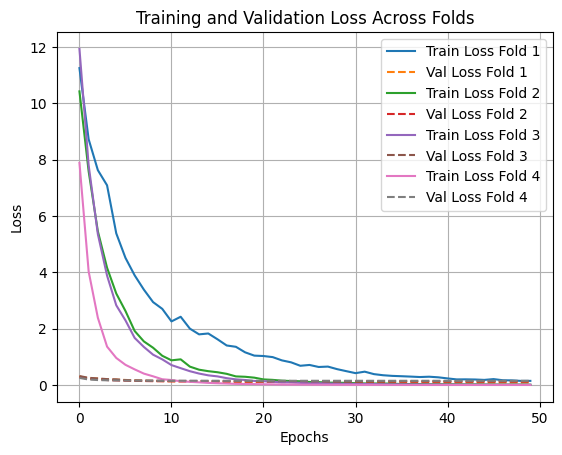

In [12]:
for fold, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
    plt.plot(train_losses, label=f'Train Loss Fold {fold + 1}')
    plt.plot(val_losses, label=f'Val Loss Fold {fold + 1}', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Folds')
plt.legend()
plt.grid(True)
plt.show()

# Train on full dataset

In [13]:
# Instantiate model
model = HybridModel(CNNFeatureExtractor())
model.apply(weights_init)
model.to(device)

# Set up the optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

# Train and evaluate the model
val_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device)

torch.save(model.state_dict(), "./trained-full-dataset-yield-density-no-leakage.pt")


# of samples - Training   - 439
# of samples - Validation - 110


 80%|████████  | 88/110 [00:29<00:07,  2.93it/s]

### Experimental Model 1

In [ ]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.flattened_size = self._get_conv_output((1, 512, 512))
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(dropout_rate)

    def _get_conv_output(self, shape):
        x = torch.rand(1, *shape)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        n_size = x.view(1, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return x

class HybridModel(nn.Module):
    def __init__(self, cnn_feature_extractor, lstm_hidden_size=16, lstm_layers=1, dropout_rate=0.6):
        super(HybridModel, self).__init__()
        self.cnn = cnn_feature_extractor
        self.lstm = nn.LSTM(input_size=64, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc1 = nn.Linear(lstm_hidden_size + 4, 32)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 512 * 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.target_shape = (512, 512)

    def forward(self, x, time_features):
        batch_size, time_steps, C, H, W = x.size()
        c_in = x.view(batch_size * time_steps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, time_steps, -1)
        r_out, (h_n, c_n) = self.lstm(r_in)
        r_out = r_out[:, -1, :]
        x = torch.cat((r_out, time_features), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = x.view(batch_size, *self.target_shape)
        return x

In [ ]:
epochs = 50

# Instantiate model
simplified_cnn = CNNFeatureExtractor(dropout_rate=0.5)
model = HybridModel(simplified_cnn, lstm_hidden_size=16, dropout_rate=0.5)
model.apply(weights_init)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

# Train and evaluate the model
val_loss, train_losses, val_losses, val_mse, val_rmse, val_mae, val_medae, val_r2  = train_and_evaluate(
    model, train_loader, val_loader, optimizer, scheduler, criterion, epochs, device
)

torch.save(model.state_dict(), "./trained-simplified-model-with-higher-dropout-512.pt")

# of samples - Training   - 439
# of samples - Validation - 110


  0%|          | 0/110 [00:00<?, ?it/s]/Users/cameron/Documents/GitHub/AgriSense-210-Capstone/train_model/inference_utils.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  evi_sequence = torch.tensor(evi_sequence, dtype=torch.float32).unsqueeze(1)
100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 1, Loss: 4.631689916957509


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.3519199086087091


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 2, Loss: 4.273416252569719


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.29978083286966595


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 3, Loss: 3.721788998083635


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.27990626224449705


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 4, Loss: 3.338194500316273


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.26013423821755816


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 5, Loss: 3.055292449214242


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.24126322673899786


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 6, Loss: 2.8667973334139045


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.22781225400311605


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 7, Loss: 2.5676532756198536


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.22015512894306863


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 8, Loss: 2.322864093563773


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2103577463754586


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 9, Loss: 2.211958567120812


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.20242579893342086


100%|██████████| 110/110 [00:37<00:00,  2.95it/s]


Epoch 10, Loss: 2.053347711129622


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.19569906565759862


100%|██████████| 110/110 [00:37<00:00,  2.94it/s]


Epoch 11, Loss: 1.8087645530700684


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17949930445424148


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 12, Loss: 1.7215926457535138


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.17302657264683927


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 13, Loss: 1.596385628526861


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16745436364518745


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 14, Loss: 1.3966663366014307


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.16630335032407725


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 15, Loss: 1.308005661314184


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1538373681583575


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 16, Loss: 1.188306927139109


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14599138059254205


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 17, Loss: 1.122570346702229


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.14102649688720703


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 18, Loss: 1.004730103503574


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13737080159730145


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 19, Loss: 0.9047233261845329


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.13376871509743588


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 20, Loss: 0.8511534010822123


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.130127779740308


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 21, Loss: 0.7507792191071944


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12715518421360425


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 22, Loss: 0.7314596815542741


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1251008180635316


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 23, Loss: 0.6314393059773878


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.12168763398325869


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 24, Loss: 0.573679846254262


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11916760115751199


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 25, Loss: 0.58009705462239


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11675642763397523


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 26, Loss: 0.4928883747621016


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11498975680608835


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 27, Loss: 0.4618495765057477


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11254946538247168


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 28, Loss: 0.43267082341692664


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.11009219764465732


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 29, Loss: 0.37892718531868674


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10988409128705305


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 30, Loss: 0.3708400017158552


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1077814551868609


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 31, Loss: 0.33590464568273587


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10575041899989758


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 32, Loss: 0.3047001018442891


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10465831801827465


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 33, Loss: 0.27631014971570533


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10371210800284254


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 34, Loss: 0.25107780600135976


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10286722279020719


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 35, Loss: 0.22380761632865126


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10153605433047883


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 36, Loss: 0.19908999722789633


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.10044001664833299


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 37, Loss: 0.19025295312431725


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09959700996322292


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 38, Loss: 0.17054241284389388


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09914900345860847


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 39, Loss: 0.15203089859675278


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09885758619722244


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 40, Loss: 0.14881811942905188


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09786470747453027


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 41, Loss: 0.12462733872234821


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.0971722340577149


100%|██████████| 110/110 [00:37<00:00,  2.90it/s]


Epoch 42, Loss: 0.12438907420093363


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09635602002630808


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 43, Loss: 0.11506375961683013


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09633703019270408


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 44, Loss: 0.1029937290332534


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09577091561264492


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 45, Loss: 0.09422915428876877


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09512638947593846


100%|██████████| 110/110 [00:37<00:00,  2.93it/s]


Epoch 46, Loss: 0.0892234816300598


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09500034926791809


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 47, Loss: 0.07419176022098824


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09477706787375999


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 48, Loss: 0.07191243267364122


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09452870695219774


100%|██████████| 110/110 [00:37<00:00,  2.91it/s]


Epoch 49, Loss: 0.0640173484063284


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.09415353283319357


100%|██████████| 110/110 [00:37<00:00,  2.92it/s]


Epoch 50, Loss: 0.05886246231807904
Validation Loss: 0.0937926740048819


/Users/cameron/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Final Validation Set Metrics - MSE: 0.09457647055387497, RMSE: 0.3075328767299652, MAE: 0.21792927384376526, R-squared: -0.9692188762722036


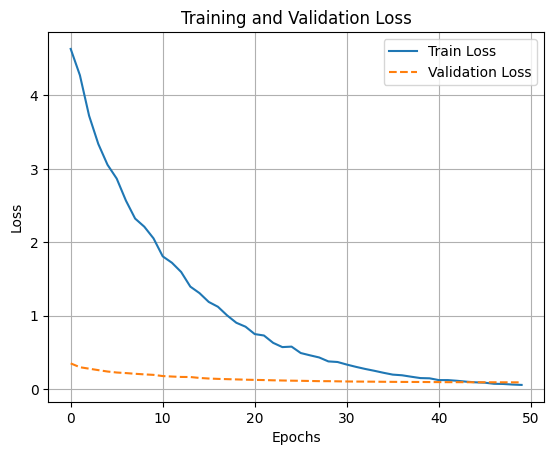

Validation MSE: 0.09457647055387497
Validation RMSE: 0.3075328767299652
Validation MAE: 0.21792927384376526
Validation R-squared: -0.9692188762722036


In [ ]:
# Plotting training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print validation performance metrics
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MAE: {val_mae}")
print(f"Validation R-squared: {val_r2}")
print(f"Validation Median Absolute Error: {val_medae}")

# Inference

In [ ]:
import joblib

# load in model from file
# inf_model_weights = torch.load("trained-full-dataset.pt", weights_only=True)
inf_model_weights = torch.load("trained-full-dataset-yield-density-no-leakage.pt", weights_only=True)
inf_model = HybridModel(CNNFeatureExtractor())
inf_model.load_state_dict(inf_model_weights)
inf_model.to(device)
inf_model.eval()

scaler = joblib.load("yield_scaler.save")

In [ ]:

# inf_output = inf_model(evi_val, time_features_val)

# print(f"{evi_val.shape = }")
# print(f"{time_features_val.shape = }")
# print(f"{inf_output.shape = }")

In [ ]:
yield_data_weekly.iloc[0].name

Timestamp('2012-03-04 00:00:00')

In [ ]:

evi_data_dir = "./landsat_evi_monterey_masked"
dataset_loader, _, mean, std = prepare_dataset(evi_data_dir, yield_data_weekly, target_shape, augment=True, full=True)

Processed file 1/83 in 4.125449s
Processed file 2/83 in 4.246559s
Processed file 3/83 in 4.898093s
Processed file 4/83 in 4.672359s
Processed file 5/83 in 5.460909s
Processed file 6/83 in 4.038937s
Processed file 7/83 in 3.490030s
Processed file 8/83 in 4.127463s
Processed file 9/83 in 3.800272s
Processed file 10/83 in 3.523895s
Processed file 11/83 in 3.932964s
Processed file 12/83 in 3.734574s
Processed file 13/83 in 4.148887s
Processed file 14/83 in 4.548136s
Processed file 15/83 in 3.748950s
Processed file 16/83 in 3.109021s
Processed file 17/83 in 4.015578s
Processed file 18/83 in 4.144617s
Processed file 19/83 in 3.917441s
Processed file 20/83 in 4.372727s
Processed file 21/83 in 4.537723s
Processed file 22/83 in 3.373776s
Processed file 23/83 in 3.701019s
Processed file 24/83 in 3.277262s
Processed file 25/83 in 3.982489s
Processed file 26/83 in 4.063423s
Processed file 27/83 in 3.969857s
Processed file 28/83 in 3.823087s
Processed file 29/83 in 4.417579s
Processed file 30/83 in

In [ ]:
timestamps = torch.Tensor()
yield_labels = torch.Tensor()
predictions = torch.Tensor()

for idx, (inputs, labels, time_features, timestamp) in enumerate(dataset_loader):
    print(f"Running inference... {idx/len(dataset_loader)*100:.2f}%", end='\r')
    inputs, labels, time_features = inputs.to(device), labels.to(device), time_features.to(device)
    outputs = inf_model(inputs, time_features)
    summed_outputs = outputs.sum(dim=(1,2))

    if idx >0:
        break
    timestamps = torch.cat((timestamps, timestamp))
    yield_labels = torch.cat((yield_labels, labels.to("cpu")))
    predictions = torch.cat((predictions, summed_outputs.to("cpu")))

    # loss = criterion(outputs, labels)
    # val_loss += loss.item()

# val_loss /= len(val_loader)
# print(f'Validation Loss: {val_loss}')

In [ ]:
yield_labels.reshape(-1,1)

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
scaler.inverse_transform(yield_labels.reshape(-1, 1))

array([[20429036.3072927 ],
       [39287413.27969694],
       [22990931.39602876],
       [       0.        ]])

In [ ]:
scaler.inverse_transform(predictions.detach().numpy().reshape(-1,1))

array([[1023663.94],
       [1020795.2 ],
       [1033442.56],
       [ 977205.5 ]], dtype=float32)

In [ ]:
yield_labels

tensor([0.4385, 0.8434, 0.4935, 0.0000])

In [ ]:
yield_data_weekly

,Volume (Pounds),Cumulative Volumne (Pounds),Pounds/Acre,month_sin,month_cos,day_of_year_sin,day_of_year_cos
Date,,,,,,,
2012-03-04,0.011286,1785843.0,18.333333,1.000000e+00,6.123234e-17,0.891981,0.452072
2012-03-11,0.063317,4735377.0,51.666667,1.000000e+00,6.123234e-17,0.939856,0.341571
2012-03-18,0.102446,9507645.0,83.500000,1.000000e+00,6.123234e-17,0.974100,0.226116
2012-03-25,0.067456,12649959.0,55.000000,1.000000e+00,6.123234e-17,0.994218,0.107381
2012-04-01,0.134627,18921357.0,93.857143,8.660254e-01,-5.000000e-01,0.999917,-0.012910
...,...,...,...,...,...,...,...
2024-05-12,0.767907,682790517.0,305.285714,5.000000e-01,-8.660254e-01,0.752667,-0.658402
2024-05-19,0.787426,682790517.0,365.166667,5.000000e-01,-8.660254e-01,0.668064,-0.744104
2024-05-26,0.827681,682790517.0,329.285714,5.000000e-01,-8.660254e-01,0.573772,-0.819015


In [ ]:
timestamps, yield_labels, predictions

In [ ]:
yield_data_weekly

In [ ]:
out_df = pd.DataFrame(data={"timestamp":timestamps.to_numpy(), "prediction":predictions.to_numpy(), "truth":yield_labels.to_numpy()})
out_df.to_csv("out.csv")